In [7]:
import pandas as pd
import geopandas as gpd
import h3
import h3pandas
import os
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
# !pip install descartes
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

Prep the network

In [2]:
# ## Takes 12 minutes

# # load the street network in Greater London
# G = ox.graph_from_place('Greater London, UK', network_type='walk')
# G = ox.project_graph(G, to_crs='EPSG:27700') # Project graph to British National Grid

# # export the graph to local as graphml
# ox.io.save_graphml(G, filepath=os.path.join('data','cleaned','G.graphml'))

In [2]:
# load graph from graphml, pre-created
G = ox.io.load_graphml(os.path.join('data','cleaned','G.graphml'))

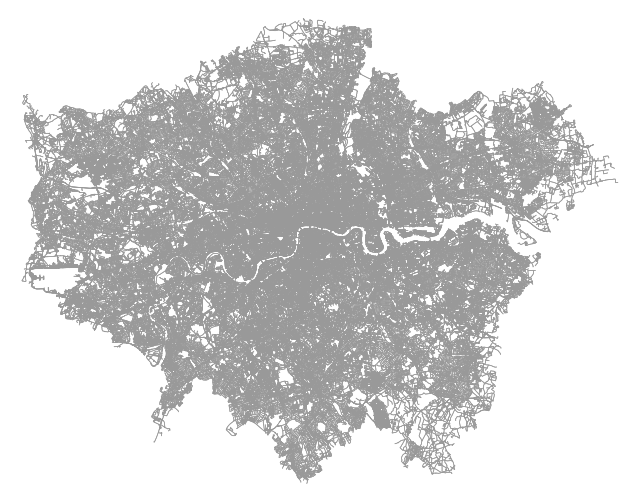

In [3]:
# plot the graph
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='w', show=False, close=False)

Functions to find isochrone from single point

In [4]:
# Function to get isochrone polygons from a center node on a graph
def make_iso_polys(G, center_node, edge_buff=25, node_buff=50):
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        isochrone_polys = gpd.GeoSeries(all_gs).unary_union
    
    return isochrone_polys

# Wrapper Function to get isochrone from a point geometry
def get_isochrone_walk(point):
    
    global G
    x, y = point.x, point.y # Define point coords
    center_node = ox.nearest_nodes(G, x, y) # Find center node

    # get the isochrone polygons
    isochrone_polys = make_iso_polys(G, center_node, edge_buff=25, node_buff=0)
    
    return isochrone_polys

# Wrapper Function to plot isochrone
def plot_isochrone(point):

    global G
    x, y = point.x, point.y # Define point coords
    center_node = ox.nearest_nodes(G, x, y) # Find center node

    # get the isochrone polygons
    isochrone_polys = make_iso_polys(G, center_node, edge_buff=25, node_buff=0)

    # plot it
    iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,node_size=0, bgcolor='k')
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    plt.show()

Create seed points from hex

In [17]:
london = ox.geocode_to_gdf('Greater London, UK')
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))


In [33]:
# polyfill london, res 9
res = 9
london_hex = london.h3.polyfill_resample(res)
london_hex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 16890 entries, 89195da4247ffff to 89195da5523ffff
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         16890 non-null  int64   
 1   geometry      16890 non-null  geometry
 2   bbox_north    16890 non-null  float64 
 3   bbox_south    16890 non-null  float64 
 4   bbox_east     16890 non-null  float64 
 5   bbox_west     16890 non-null  float64 
 6   place_id      16890 non-null  int64   
 7   osm_type      16890 non-null  object  
 8   osm_id        16890 non-null  int64   
 9   lat           16890 non-null  float64 
 10  lon           16890 non-null  float64 
 11  class         16890 non-null  object  
 12  type          16890 non-null  object  
 13  place_rank    16890 non-null  int64   
 14  importance    16890 non-null  float64 
 15  addresstype   16890 non-null  object  
 16  name          16890 non-null  object  
 17  display_name  16890 non

In [ ]:
# get centroids
london_hex = london_hex.to_crs('EPSG:27700')
london_hex['geometry'] = london_hex['geometry'].centroid
london_hex = london_hex.set_geometry('geometry')


<Axes: >

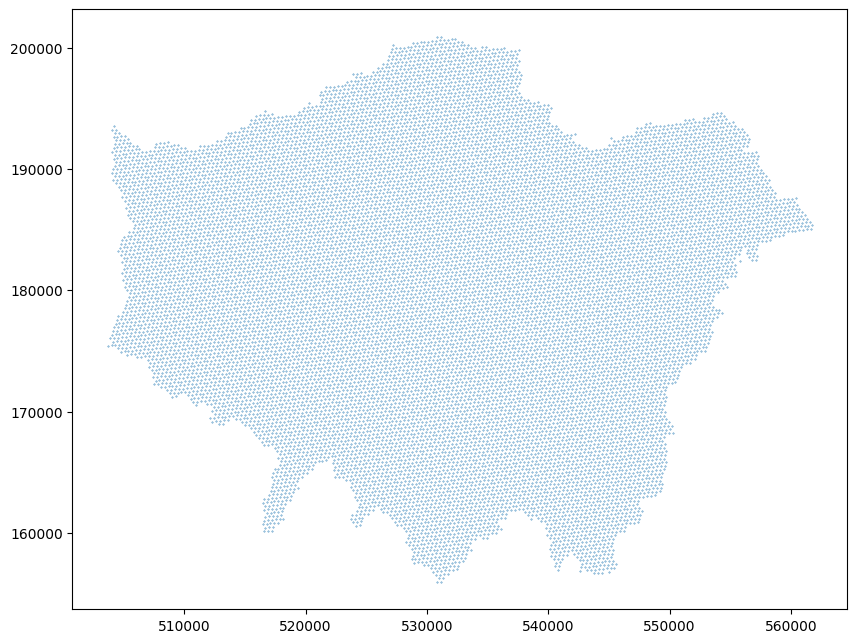

In [38]:
london_hex.plot(markersize=0.1, figsize=(10,10))

Create 15-minute isochrones

In [44]:
df = london_hex[['geometry']].reset_index()
df

,h3_polyfill,geometry
0,89195da4247ffff,POINT (522410.532 188229.043)
1,89194ad9e43ffff,POINT (513931.470 171117.255)
2,89194ad342bffff,POINT (534225.029 182314.803)
3,89194adb167ffff,POINT (518965.516 176651.839)
4,89195da54c7ffff,POINT (519969.998 192713.765)
...,...,...
16885,89194ac36c7ffff,POINT (526625.585 168545.304)
16886,89194e6a98fffff,POINT (548810.590 187016.519)
16887,89194ad9303ffff,POINT (513295.825 172829.449)
16888,89194e6e36fffff,POINT (553686.703 178059.103)


In [46]:
%%time

# configure te place, network type, trip times, and travel speed
network_type = 'walk'
trip_times = [15] #in minutes

# split the flow_bus dataset into chunks of 1000 rows
df_chunks = [df[i:i+1000] for i in range(0, df.shape[0], 1000)]

# create folder if not exists
if not os.path.exists(os.path.join('data','cleaned','new_isochrone_15m')):
    os.makedirs(os.path.join('data','cleaned','new_isochrone_15m'))

# create isochrone polygons for each chunk and then export
for i, chunk in enumerate(df_chunks): # skip the first chunk
    print(f'Processing chunk {i+1} out of {len(df_chunks)}...')       
    # add isochrone polygons to flow_bus
    chunk['isochrone'] = chunk.geometry.apply(get_isochrone_walk) # get isochrone
    chunk.drop(columns='geometry',inplace=True) # drop the old geometry column
    chunk.rename(columns={'isochrone':'geometry'},inplace=True) # rename the new geometry column
    chunk = gpd.GeoDataFrame(chunk, geometry='geometry', crs='EPSG:27700') # convert to geodataframe and drop the old geometry column

    # export chunk
    chunk.to_file(os.path.join('data','cleaned','new_isochrone_15m','new_isochrone_{}.gpkg'.format(i)), driver='GPKG')

Processing chunk 1 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 2 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 3 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 4 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 5 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 6 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 7 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 8 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 9 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 10 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 11 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 12 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 13 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 14 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 15 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 16 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing chunk 17 out of 18...


C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 3h 51min 1s
Wall time: 9h 36min 13s


In [47]:
# import all the flow_bus_isochrone datasets from files into a list
isochrone_list = []
for i in range(len(df_chunks)):
    isochrone_list.append(gpd.read_file(os.path.join('data','cleaned','new_isochrone_15m','new_isochrone_{}.gpkg'.format(i))))

# concatenate all the flow_bus_isochrone datasets into one
new_isochrone = pd.concat(isochrone_list)
new_isochrone.reset_index(inplace=True,drop=True)
new_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   h3_polyfill  16890 non-null  object  
 1   geometry     16890 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 264.0+ KB


In [49]:
#rename column to id_code
new_isochrone.rename(columns={'h3_polyfill':'id_code'},inplace=True)
new_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16890 entries, 0 to 16889
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   16890 non-null  object  
 1   geometry  16890 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 264.0+ KB


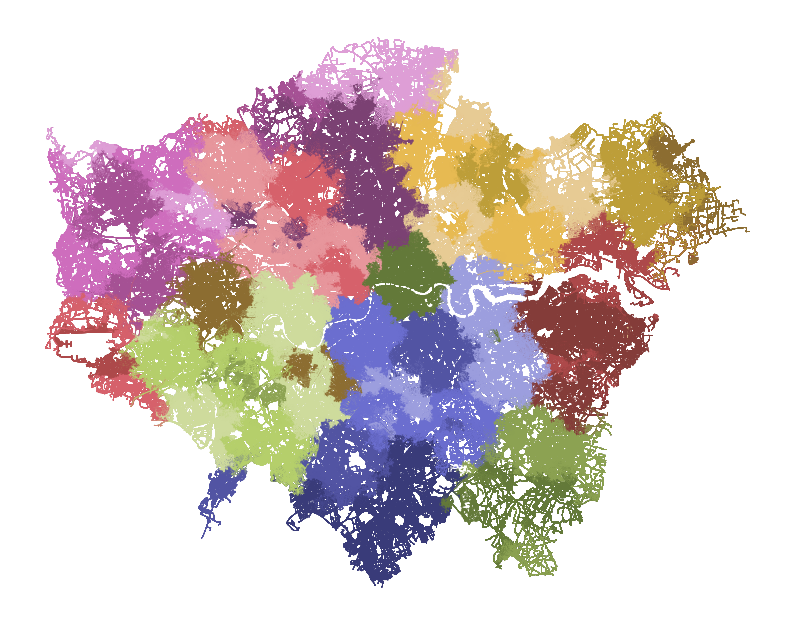

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
new_isochrone.plot(ax=ax, column='id_code', cmap='tab20b')
plt.axis('off')
plt.show()

Export 15-minute isochrones

In [55]:
new_isochrone.to_csv(os.path.join('data','cleaned','new_isochrone_15m.csv'),index=False)